In [241]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [242]:
#Device agnositc

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create a dataset by sklearn

In [262]:
from sklearn.datasets import make_moons

X,Y = make_moons(n_samples = 1000, noise = 0.1, random_state = 42)

#Turn into a tensor
X,Y = torch.from_numpy(X).type(torch.float32), torch.from_numpy(Y).type(torch.float)

#Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size =0.8, random_state = 42)


In [263]:
Y.unique()

tensor([0., 1.])

Train dataset | Shape: torch.Size([800, 2]), Dtype : torch.float32, Label : torch.float32
Test dataset | Shape: torch.Size([200, 2]), Dtype : torch.float32, Label : torch.Size([200])


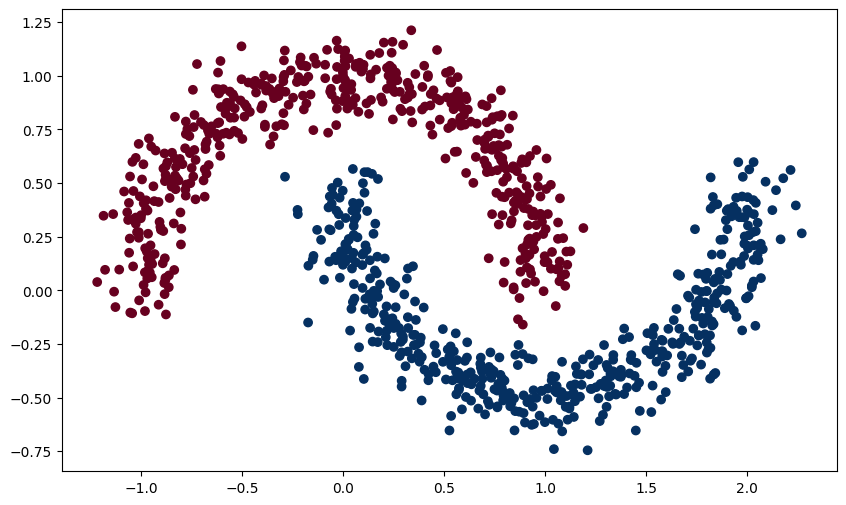

In [264]:
#Check the information of dataset

print(f"Train dataset | Shape: {X_train.shape}, Dtype : {X_train.dtype}, Label : {Y_train.dtype}")
print(f"Test dataset | Shape: {X_test.shape}, Dtype : {X_test.dtype}, Label : {Y_test.shape}")

plt.figure(figsize = (10,6))
plt.scatter(X[:,0], X[:,1], c = Y[:], cmap = "RdBu")

In [265]:
class MoonClassification(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_stack_layer = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 8),
        nn.ReLU(),
        nn.Linear(in_features = 8, out_features = 16),
        nn.ReLU(),
        nn.Linear(in_features = 16, out_features = 8),
        nn.ReLU(),
        nn.Linear(in_features = 8, out_features = 1)
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_stack_layer(x)


model = MoonClassification().to(device)
model

MoonClassification(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [266]:
#Loss function and optimizer pick

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.1)

In [267]:
#Accuracy check

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

# Training loop

In [268]:
#Put to the device!
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

In [269]:
epochs = 1000

for epoch in range(epochs):
  model.train()

  train_logits = model(X_train).squeeze()
  train_pred = torch.round(torch.sigmoid(train_logits))

  train_loss = loss_fn(train_logits, Y_train)
  train_acc = accuracy_fn(Y_train, train_pred)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()


  #Eval
  model.eval()

  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, Y_test)
    test_acc = accuracy_fn(Y_test, test_pred)


  #Visualize status of training each 100 epochs
  if epoch%100 == 0:
   print(f"Epoch: {epoch} | Train loss : {train_loss:.4f}, Train accuracy : {train_acc : .2f}% | Test loss: {test_loss :.4f}, Test accuracy: {test_acc: .2f}%")



Epoch: 0 | Train loss : 0.6993, Train accuracy :  50.00% | Test loss: 0.6306, Test accuracy:  69.00%
Epoch: 100 | Train loss : 0.0153, Train accuracy :  99.25% | Test loss: 0.0101, Test accuracy:  99.50%
Epoch: 200 | Train loss : 0.0004, Train accuracy :  100.00% | Test loss: 0.0003, Test accuracy:  100.00%
Epoch: 300 | Train loss : 0.0002, Train accuracy :  100.00% | Test loss: 0.0002, Test accuracy:  100.00%
Epoch: 400 | Train loss : 0.0001, Train accuracy :  100.00% | Test loss: 0.0001, Test accuracy:  100.00%
Epoch: 500 | Train loss : 0.0001, Train accuracy :  100.00% | Test loss: 0.0001, Test accuracy:  100.00%
Epoch: 600 | Train loss : 0.0001, Train accuracy :  100.00% | Test loss: 0.0001, Test accuracy:  100.00%
Epoch: 700 | Train loss : 0.0000, Train accuracy :  100.00% | Test loss: 0.0000, Test accuracy:  100.00%
Epoch: 800 | Train loss : 0.0000, Train accuracy :  100.00% | Test loss: 0.0000, Test accuracy:  100.00%
Epoch: 900 | Train loss : 0.0000, Train accuracy :  100.00% |

# Visualize the evaluation

In [270]:
import requests
from pathlib import Path

if Path("helper_function.py").is_file():
  print("helper_function.py already exist. Skipping download")
else:
  print("Downloading helper_function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import plot_decision_boundary

helper_function.py already exist. Skipping download


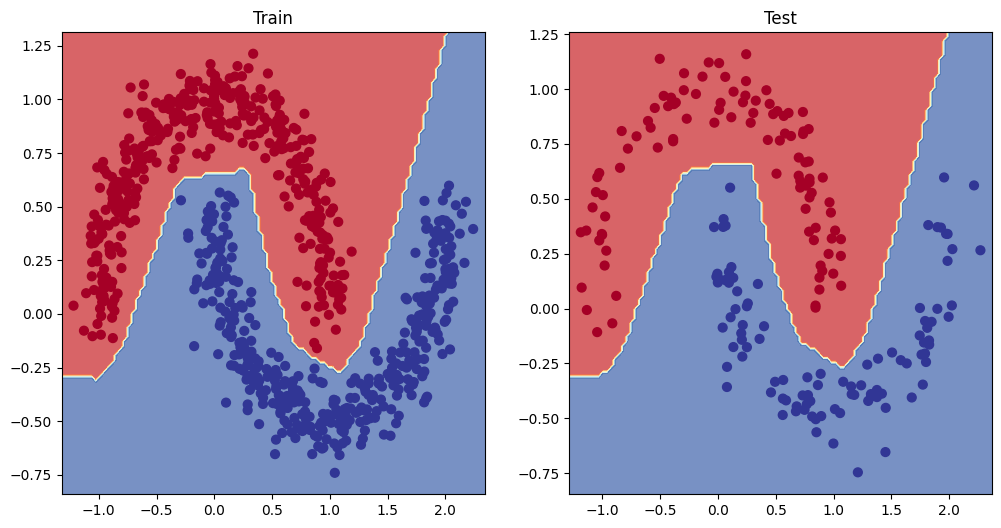

In [271]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, Y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, X_test, Y_test)

In [273]:
from pathlib import Path

MODEL_directory = Path("make_moon")
MODEL_directory.mkdir(parents = True, exist_ok = True)

MODEL_save_name = "moon.pth"
MODEL_save_path = MODEL_directory/MODEL_save_name

torch.save(obj=model.state_dict(), f= MODEL_save_path)